In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error,  accuracy_score, precision_score, recall_score, f1_score

def groubpy_func_class_metrics(df, pred_column):
    count = df.shape[0]
    dist = {}
    #print(df)

    out = pd.DataFrame(index = [0])

    out['count'] = count

    for i in range(1, 6):
        out['dist_' + str(i)] = df[df['label'] == i].shape[0]
    
    accuracy_metric = accuracy_score(df['label'], df[pred_column])

    out['accuracy'] = accuracy_metric

    out['precision_micro'] = precision_score(df['label'], df[pred_column], average='weighted', zero_division = np.nan)
    out['recall_micro'] = recall_score(df['label'], df[pred_column], average='weighted', zero_division = np.nan)
    out['f1_score_micro'] = f1_score(df['label'], df[pred_column],  average='weighted', zero_division = np.nan)



    #print(out)
    return out

def id_to_name(id, df_informal_names):
    id_tmp = int(id)
    if id == -1:
        return -1
    else:
        try:
            return df_informal_names.loc[id,:]['EMITENT_FULL_NAME']
        except:
            return id

In [3]:
issuers = pd.read_csv('../../../data/issuers - issuers.csv', index_col = 1).drop('ID человека', axis= 1)

In [4]:
with open('../../../data/messages_many_2/messages_many.pkl', 'rb') as file:

    mes_many = pickle.load(file)

In [5]:
mentions = pd.read_csv('../../../data/sentiment_data_3/mentions.csv', index_col = 0)
mentions = mentions[mentions['issuerid'] > 0]
mentions = mentions.rename(columns={'messageid': 'MessageID'})

In [6]:
sentiment = pd.read_csv('../../../data/sentiment_data_3/sentiment.csv', index_col = 0)
#sentiment = sentiment[sentiment['issuerid'] > 0]
sentiment = sentiment[sentiment['SentimentScore'] != 0]

In [7]:
tmp = sentiment.copy()
tmp['issuerid'] = sentiment['issuerid'].astype('str')
tmp = tmp.groupby(['ChannelID', 'MessageID']).apply(lambda x: list(zip(x['issuerid'].to_list(), x['SentimentScore'].to_list()))).reset_index()
mes_many_issuers_sentiment  = mes_many.merge(tmp, on = ['ChannelID', 'MessageID'], how ='right')
mes_many_issuers_sentiment = mes_many_issuers_sentiment.dropna()
mes_many_issuers_sentiment = mes_many_issuers_sentiment.rename(columns={0: 'sentiment'})

In [8]:
mes_many_issuers_sentiment

,MessageID,ChannelID,DateAdded,DatePosted,MessageText,IsForward,sentiment
0,103,1001029560,2021-02-06 00:52:00,2016-01-14 07:15:26,http://bcs-express.ru/novosti-i-analitika/prog...,False,"[(-1, 3)]"
1,513,1001029560,2021-02-06 00:52:00,2016-06-09 09:47:40,http://bcs-express.ru/novosti-i-analitika/divi...,False,"[(-1, 3)]"
2,6495,1001029560,2021-02-06 00:52:00,2020-09-24 09:46:38,Группа Mail.ru планирует привлечь $600 млн для...,False,"[(-1, 3)]"
3,7869,1001029560,2021-08-11 02:02:52,2021-08-10 15:58:19,Рыночная стоимость Сбербанка превысила $100 мл...,False,"[(-1, 3)]"
4,12838,1001029560,2023-01-23 20:37:25,2023-01-23 15:02:06,​​🎉 Конкурс — Норильский никель после отчетнос...,False,"[(53, 3)]"
...,...,...,...,...,...,...,...
7450,1627,1565800335,2023-06-16 13:23:06,2023-06-16 07:30:00,​🔎 АФК Система (AFKS) - вот кто может оказатьс...,False,"[(204, 3)]"
7451,1632,1565800335,2023-06-19 13:25:14,2023-06-19 07:30:15,​​💎 Алроса (ALRS) - актуализация взгляда на фо...,False,"[(4, 5), (127, 4)]"
7452,1641,1565800335,2023-06-22 13:24:38,2023-06-22 08:32:09,"""​🔥 Новатэк (NVTK) - новые данные с ПМЭФ и про...",False,"[(115, 2)]"
7453,1664,1565800335,2023-07-03 19:32:23,2023-07-03 15:24:56,"⚡ Идеи, которые еще не потеряли актуальность ...",False,"[(12, 4), (4, 4), (111, 4), (53, 4), (58, 4)]"


In [9]:
mes_many_issuers_sentiment['label'] = mes_many_issuers_sentiment['sentiment'].apply(lambda x : x[0][1]) -1

In [10]:
mes_many_issuers_sentiment = mes_many_issuers_sentiment[mes_many_issuers_sentiment['sentiment'].str.len() == 1].copy()

In [11]:
mes_many_issuers_sentiment['name'] = mes_many_issuers_sentiment['sentiment'].apply(lambda x : x[0][0]).astype(int).map(lambda x: id_to_name(x, issuers))

In [12]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(mes_many_issuers_sentiment[['MessageText', 'label', 'name']], test_size=0.2, random_state = 42, stratify=mes_many_issuers_sentiment['label'])

<Axes: ylabel='Frequency'>

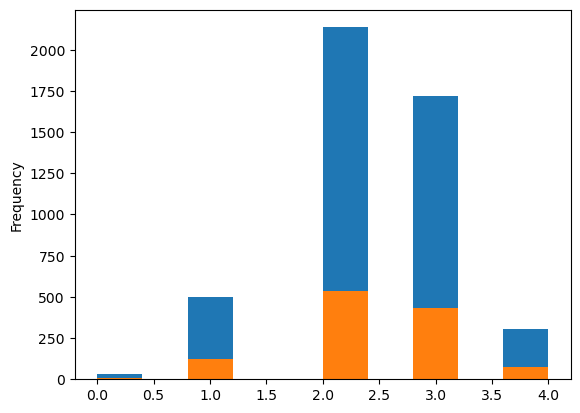

In [13]:
train_df['label'].plot.hist()
test_df['label'].plot.hist()

In [14]:
mes_many_issuers_sentiment['label'].value_counts(normalize = False, sort =  False)/ \
    mes_many_issuers_sentiment['label'].value_counts(normalize = False, sort =  False).max()

label
2    1.000000
3    0.804120
1    0.234457
4    0.142322
0    0.016479
Name: count, dtype: float64

In [15]:
weights = (1/(mes_many_issuers_sentiment['label'].value_counts(normalize = False, sort =  False)/ \
    mes_many_issuers_sentiment['label'].value_counts(normalize = False, sort =  False).max())).to_dict()

In [16]:
weights[0] = 10

In [17]:
weights

{2: 1.0,
 3: 1.2435957149510946,
 1: 4.26517571884984,
 4: 7.026315789473685,
 0: 10}

In [18]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline
from datasets import Dataset
import torch
import torch.nn as nn

In [19]:
"""import importlib
import funcs #import the module here, so that it can be reloaded.
importlib.reload(funcs)

def create_tokenized_by_chuncs_from_df(df):
    res = []
    for index, row in df.iterrows():
        if len(tokenizer(row['MessageText'], truncation=True, max_length=512)['input_ids']) == 512:
            
            out = funcs.transform_single_text(row['MessageText'], tokenizer, 510, 260, 10, None)

            for i in range(out[0].shape[0]):
                item = {}

                item['MessageText'] = row['MessageText']
                item['input_ids'] = out[0][i]
                item['attention_mask'] = out[1][i]
                item['label'] = row['label']
                res += [item]

        else:
            out = tokenizer(row['MessageText'], padding='max_length', truncation=True, max_length=512)
            item = {}
            item['MessageText'] = row['MessageText']
            item['input_ids'] = out['input_ids']
            item['attention_mask'] = out['attention_mask']
            item['label'] = row['label']
            res += [item]
                

    return Dataset.from_list(res)"""

"import importlib\nimport funcs #import the module here, so that it can be reloaded.\nimportlib.reload(funcs)\n\ndef create_tokenized_by_chuncs_from_df(df):\n    res = []\n    for index, row in df.iterrows():\n        if len(tokenizer(row['MessageText'], truncation=True, max_length=512)['input_ids']) == 512:\n            \n            out = funcs.transform_single_text(row['MessageText'], tokenizer, 510, 260, 10, None)\n\n            for i in range(out[0].shape[0]):\n                item = {}\n\n                item['MessageText'] = row['MessageText']\n                item['input_ids'] = out[0][i]\n                item['attention_mask'] = out[1][i]\n                item['label'] = row['label']\n                res += [item]\n\n        else:\n            out = tokenizer(row['MessageText'], padding='max_length', truncation=True, max_length=512)\n            item = {}\n            item['MessageText'] = row['MessageText']\n            item['input_ids'] = out['input_ids']\n            item['

In [20]:
train_df

,MessageText,label,name
4294,"""🇷🇺#мясо #россия объем экспорта мяса из Росси...",3,"Публичное акционерное общество ""Группа Черкизово"""
523,​Positive Technologies стала кандидатом в инде...,3,КИВИ ПиЭлСи (QIWI PLC) (эмитент депозитарных р...
7216,Спасибо санкциям за прибыль. С каким отчетом в...,3,Публичная Компания с ограниченной ответственно...
5417,💥🇷🇺#CIAN #листинг ЦИАН подал на регистрацию в...,3,Cian PLC (эмитент депозитарных расписок - The ...
5292,🇷🇺#YNDX #отчетность Выручка платформы Yandex ...,3,Публичная Компания с ограниченной ответственно...
...,...,...,...
3010,"""??#GAZP #северныйпоток2 #турецкийпоток Nord S...",2,-1
1941,"""#WTCM #Раскрытия ?? Совет директоров ПАО """"ЦМ...",2,-1
2913,FEES - IRAO «ИНТЕР РАО» НЕ ОБСУЖДАЕТ ВЫКУП У Ф...,2,-1
1437,Акции Лукойла на хороших объемах закрылись в ч...,2,"Публичное акционерное общество ""Нефтяная компа..."


In [21]:
train_ds = Dataset.from_pandas(train_df[['MessageText', 'label']], split="train", preserve_index=False)
test_ds = Dataset.from_pandas(test_df[['MessageText', 'label']], split="test", preserve_index=False)

/home/kir/miniconda3/envs/my/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/kir/miniconda3/envs/my/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [22]:
#model_name = 'ai-forever/ruBert-large'
#model_name = 'DeepPavlov/rubert-base-cased'
#model_name = 'cointegrated/rubert-tiny2'

tokenizer_path = r'../../../1st semestr/rubert_my_v2_tokinizer'
model_path = r'../../../1st semestr/rubert_my_v2'


if 'model_name' in globals() :
    tokenizer_path = model_name
    model_path = model_name

attention_probs_dropout_prob = 0.2
hidden_dropout_prob = 0.2
classifier_dropout = 0.2

In [23]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
if model_path == 'cointegrated/rubert-tiny2':
    tokenizer.model_max_length = 2048
else:
    tokenizer.model_max_length = 512

In [24]:
def preprocess_function(examples):

    return tokenizer(examples["MessageText"], truncation=True, max_length=tokenizer.model_max_length)

In [25]:
tokenized_train_ds = train_ds.map(preprocess_function, batched=True)
tokenized_test_ds = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/4693 [00:00<?, ? examples/s]

Map:   0%|          | 0/1174 [00:00<?, ? examples/s]

In [26]:
tokenized_train_ds

Dataset({
    features: ['MessageText', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4693
})

In [27]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [28]:
#tokenized_train_ds = create_tokenized_by_chuncs_from_df(train_df[['MessageText', 'label']])
#tokenized_test_ds = create_tokenized_by_chuncs_from_df(test_df[['MessageText', 'label']])

In [29]:
tokenized_train_ds

Dataset({
    features: ['MessageText', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4693
})

In [30]:
id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
label2id = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

#id2label = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=5, id2label = id2label, label2id = id2label,
                                                            attention_probs_dropout_prob=attention_probs_dropout_prob,
                                                            hidden_dropout_prob=hidden_dropout_prob,
                                                            classifier_dropout = classifier_dropout
                                                            )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../../../1st semestr/rubert_my_v2 and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'bert.pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
from peft import LoraConfig, TaskType, get_peft_model

model_tmp = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=5,# id2label = id2label, label2id = id2label,
                                                            #attention_probs_dropout_prob=attention_probs_dropout_prob,
                                                            #hidden_dropout_prob=hidden_dropout_prob,
                                                            #classifier_dropout = classifier_dropout
                                                            )


"""modules = [model_lora.base_model.embeddings, model_lora.base_model.encoder.layer[:-]] 
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

for param in model_lora.bert.parameters():
    param.requires_grad = False

for param in model_lora.bert.encoder.layer[-1].parameters():
    param.requires_grad = True"""

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=1, lora_alpha=1, lora_dropout=0.1
)
model_lora = get_peft_model(model_tmp, lora_config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../../../1st semestr/rubert_my_v2 and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'bert.pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
"""modules = [model_lora.base_model.base_model.embeddings, model_lora.base_model.base_model.encoder.layer[:-2]] 
for module in modules:
    for param in module.parameters():
        param.requires_grad = False"""

'modules = [model_lora.base_model.base_model.embeddings, model_lora.base_model.base_model.encoder.layer[:-2]] \nfor module in modules:\n    for param in module.parameters():\n        param.requires_grad = False'

In [34]:
model_lora.print_trainable_parameters()

trainable params: 44,554 || all params: 179,340,298 || trainable%: 0.024843273094148646


In [35]:
import evaluate

accuracy = evaluate.load("accuracy")

In [36]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [37]:
weights_tensor = torch.tensor([weights[i] for i in range(0, 5)])

In [38]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([weights[i] for i in range(5)], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [39]:
torch.backends.cuda.matmul.allow_tf32 = True

In [40]:
torch.backends.cudnn.allow_tf32 = True

In [41]:
modules = [model.base_model.embeddings, model.base_model.encoder.layer[:-4]] 
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

In [42]:
training_args_bert_base = TrainingArguments(
    output_dir="test",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=20,
    num_train_epochs=60,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_strategy="steps",
    logging_strategy = 'steps',
    evaluation_strategy = 'steps',
    logging_steps = 100,
    eval_steps = 100,
    save_steps = 1000,
    tf32=True,
    #bf16=True,
    group_by_length=True
)

In [43]:
training_args_bert_large = TrainingArguments(
    output_dir="test",
    learning_rate=5e-5,
    per_device_train_batch_size=14,
    per_device_eval_batch_size=20,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_strategy="steps",
    logging_strategy = 'steps',
    evaluation_strategy = 'steps',
    logging_steps = 100,
    eval_steps = 100,
    save_steps = 100,
    tf32=True,
    #bf16=True,
    group_by_length=True
)

In [44]:
trainer = CustomTrainer(
    model=model,
    args=training_args_bert_base,
    train_dataset=tokenized_train_ds, 
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [45]:
trainer.train()

  0%|          | 0/17640 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.5346, 'learning_rate': 9.943310657596372e-06, 'epoch': 0.34}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.4314680099487305, 'eval_accuracy': 0.3126064735945486, 'eval_runtime': 10.6553, 'eval_samples_per_second': 110.18, 'eval_steps_per_second': 5.537, 'epoch': 0.34}
{'loss': 1.3992, 'learning_rate': 9.886621315192746e-06, 'epoch': 0.68}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3110967874526978, 'eval_accuracy': 0.49829642248722317, 'eval_runtime': 8.9183, 'eval_samples_per_second': 131.639, 'eval_steps_per_second': 6.616, 'epoch': 0.68}
{'loss': 1.266, 'learning_rate': 9.829931972789115e-06, 'epoch': 1.02}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.1847734451293945, 'eval_accuracy': 0.5332197614991482, 'eval_runtime': 8.9353, 'eval_samples_per_second': 131.388, 'eval_steps_per_second': 6.603, 'epoch': 1.02}
{'loss': 1.1624, 'learning_rate': 9.773242630385489e-06, 'epoch': 1.36}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.1233042478561401, 'eval_accuracy': 0.5289608177172062, 'eval_runtime': 8.9281, 'eval_samples_per_second': 131.496, 'eval_steps_per_second': 6.608, 'epoch': 1.36}
{'loss': 1.0861, 'learning_rate': 9.71655328798186e-06, 'epoch': 1.7}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.1091729402542114, 'eval_accuracy': 0.575809199318569, 'eval_runtime': 8.9544, 'eval_samples_per_second': 131.108, 'eval_steps_per_second': 6.589, 'epoch': 1.7}
{'loss': 1.0815, 'learning_rate': 9.659863945578232e-06, 'epoch': 2.04}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.048382043838501, 'eval_accuracy': 0.551107325383305, 'eval_runtime': 8.9586, 'eval_samples_per_second': 131.047, 'eval_steps_per_second': 6.586, 'epoch': 2.04}
{'loss': 0.9937, 'learning_rate': 9.603174603174605e-06, 'epoch': 2.38}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.017128825187683, 'eval_accuracy': 0.5706984667802385, 'eval_runtime': 8.9865, 'eval_samples_per_second': 130.641, 'eval_steps_per_second': 6.565, 'epoch': 2.38}
{'loss': 0.9684, 'learning_rate': 9.546485260770976e-06, 'epoch': 2.72}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0571621656417847, 'eval_accuracy': 0.620954003407155, 'eval_runtime': 8.9914, 'eval_samples_per_second': 130.568, 'eval_steps_per_second': 6.562, 'epoch': 2.72}
{'loss': 1.0037, 'learning_rate': 9.489795918367348e-06, 'epoch': 3.06}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0256303548812866, 'eval_accuracy': 0.6039182282793867, 'eval_runtime': 8.7658, 'eval_samples_per_second': 133.93, 'eval_steps_per_second': 6.731, 'epoch': 3.06}
{'loss': 0.9254, 'learning_rate': 9.43310657596372e-06, 'epoch': 3.4}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0119701623916626, 'eval_accuracy': 0.6081771720613288, 'eval_runtime': 8.7771, 'eval_samples_per_second': 133.757, 'eval_steps_per_second': 6.722, 'epoch': 3.4}
{'loss': 0.9112, 'learning_rate': 9.376417233560091e-06, 'epoch': 3.74}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0917686223983765, 'eval_accuracy': 0.5971039182282794, 'eval_runtime': 8.7849, 'eval_samples_per_second': 133.638, 'eval_steps_per_second': 6.716, 'epoch': 3.74}
{'loss': 0.8615, 'learning_rate': 9.319727891156464e-06, 'epoch': 4.08}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0847151279449463, 'eval_accuracy': 0.5936967632027257, 'eval_runtime': 8.8, 'eval_samples_per_second': 133.41, 'eval_steps_per_second': 6.705, 'epoch': 4.08}
{'loss': 0.8985, 'learning_rate': 9.263038548752836e-06, 'epoch': 4.42}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0045748949050903, 'eval_accuracy': 0.6533219761499148, 'eval_runtime': 8.8004, 'eval_samples_per_second': 133.403, 'eval_steps_per_second': 6.704, 'epoch': 4.42}
{'loss': 0.8819, 'learning_rate': 9.206349206349207e-06, 'epoch': 4.76}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.9921475648880005, 'eval_accuracy': 0.6235093696763203, 'eval_runtime': 8.81, 'eval_samples_per_second': 133.257, 'eval_steps_per_second': 6.697, 'epoch': 4.76}
{'loss': 0.8772, 'learning_rate': 9.149659863945579e-06, 'epoch': 5.1}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0328305959701538, 'eval_accuracy': 0.6090289608177172, 'eval_runtime': 8.8093, 'eval_samples_per_second': 133.268, 'eval_steps_per_second': 6.697, 'epoch': 5.1}
{'loss': 0.8539, 'learning_rate': 9.09297052154195e-06, 'epoch': 5.44}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0614787340164185, 'eval_accuracy': 0.6354344122657581, 'eval_runtime': 8.8179, 'eval_samples_per_second': 133.138, 'eval_steps_per_second': 6.691, 'epoch': 5.44}
{'loss': 0.8226, 'learning_rate': 9.036281179138324e-06, 'epoch': 5.78}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.9935582280158997, 'eval_accuracy': 0.6388415672913118, 'eval_runtime': 8.8196, 'eval_samples_per_second': 133.113, 'eval_steps_per_second': 6.69, 'epoch': 5.78}
{'loss': 0.7885, 'learning_rate': 8.979591836734695e-06, 'epoch': 6.12}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0020171403884888, 'eval_accuracy': 0.6550255536626917, 'eval_runtime': 8.8204, 'eval_samples_per_second': 133.1, 'eval_steps_per_second': 6.689, 'epoch': 6.12}
{'loss': 0.8437, 'learning_rate': 8.922902494331067e-06, 'epoch': 6.46}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.060813307762146, 'eval_accuracy': 0.6294718909710392, 'eval_runtime': 8.8297, 'eval_samples_per_second': 132.96, 'eval_steps_per_second': 6.682, 'epoch': 6.46}
{'loss': 0.7977, 'learning_rate': 8.866213151927438e-06, 'epoch': 6.8}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0358147621154785, 'eval_accuracy': 0.6218057921635435, 'eval_runtime': 8.8281, 'eval_samples_per_second': 132.985, 'eval_steps_per_second': 6.683, 'epoch': 6.8}
{'loss': 0.7568, 'learning_rate': 8.80952380952381e-06, 'epoch': 7.14}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0209137201309204, 'eval_accuracy': 0.6695059625212947, 'eval_runtime': 8.8274, 'eval_samples_per_second': 132.995, 'eval_steps_per_second': 6.684, 'epoch': 7.14}
{'loss': 0.7802, 'learning_rate': 8.752834467120183e-06, 'epoch': 7.48}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.096174716949463, 'eval_accuracy': 0.6490630323679727, 'eval_runtime': 8.8287, 'eval_samples_per_second': 132.975, 'eval_steps_per_second': 6.683, 'epoch': 7.48}
{'loss': 0.7444, 'learning_rate': 8.696145124716555e-06, 'epoch': 7.82}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.9887562394142151, 'eval_accuracy': 0.6379897785349233, 'eval_runtime': 8.8462, 'eval_samples_per_second': 132.713, 'eval_steps_per_second': 6.67, 'epoch': 7.82}
{'loss': 0.7592, 'learning_rate': 8.639455782312926e-06, 'epoch': 8.16}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0205034017562866, 'eval_accuracy': 0.6575809199318569, 'eval_runtime': 8.83, 'eval_samples_per_second': 132.956, 'eval_steps_per_second': 6.682, 'epoch': 8.16}
{'loss': 0.702, 'learning_rate': 8.582766439909298e-06, 'epoch': 8.5}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.075798749923706, 'eval_accuracy': 0.6712095400340715, 'eval_runtime': 8.8336, 'eval_samples_per_second': 132.901, 'eval_steps_per_second': 6.679, 'epoch': 8.5}
{'loss': 0.7579, 'learning_rate': 8.52607709750567e-06, 'epoch': 8.84}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0194871425628662, 'eval_accuracy': 0.6422487223168655, 'eval_runtime': 8.8387, 'eval_samples_per_second': 132.825, 'eval_steps_per_second': 6.675, 'epoch': 8.84}
{'loss': 0.7356, 'learning_rate': 8.469387755102042e-06, 'epoch': 9.18}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0187689065933228, 'eval_accuracy': 0.6473594548551959, 'eval_runtime': 8.8383, 'eval_samples_per_second': 132.831, 'eval_steps_per_second': 6.675, 'epoch': 9.18}
{'loss': 0.6921, 'learning_rate': 8.412698412698414e-06, 'epoch': 9.52}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.038492202758789, 'eval_accuracy': 0.682282793867121, 'eval_runtime': 8.8486, 'eval_samples_per_second': 132.677, 'eval_steps_per_second': 6.668, 'epoch': 9.52}
{'loss': 0.6874, 'learning_rate': 8.356009070294785e-06, 'epoch': 9.86}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0533573627471924, 'eval_accuracy': 0.6669505962521295, 'eval_runtime': 8.8311, 'eval_samples_per_second': 132.94, 'eval_steps_per_second': 6.681, 'epoch': 9.86}
{'loss': 0.674, 'learning_rate': 8.299319727891157e-06, 'epoch': 10.2}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0547511577606201, 'eval_accuracy': 0.666098807495741, 'eval_runtime': 8.8297, 'eval_samples_per_second': 132.961, 'eval_steps_per_second': 6.682, 'epoch': 10.2}
{'loss': 0.7172, 'learning_rate': 8.242630385487529e-06, 'epoch': 10.54}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0600348711013794, 'eval_accuracy': 0.6541737649063032, 'eval_runtime': 8.8238, 'eval_samples_per_second': 133.05, 'eval_steps_per_second': 6.686, 'epoch': 10.54}
{'loss': 0.653, 'learning_rate': 8.1859410430839e-06, 'epoch': 10.88}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0502926111221313, 'eval_accuracy': 0.6643952299829642, 'eval_runtime': 8.8383, 'eval_samples_per_second': 132.831, 'eval_steps_per_second': 6.675, 'epoch': 10.88}
{'loss': 0.6185, 'learning_rate': 8.129251700680273e-06, 'epoch': 11.22}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0738365650177002, 'eval_accuracy': 0.6729131175468483, 'eval_runtime': 8.8354, 'eval_samples_per_second': 132.874, 'eval_steps_per_second': 6.678, 'epoch': 11.22}
{'loss': 0.6496, 'learning_rate': 8.072562358276645e-06, 'epoch': 11.56}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0694676637649536, 'eval_accuracy': 0.6524701873935264, 'eval_runtime': 8.8281, 'eval_samples_per_second': 132.984, 'eval_steps_per_second': 6.683, 'epoch': 11.56}
{'loss': 0.6561, 'learning_rate': 8.015873015873016e-06, 'epoch': 11.9}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0727437734603882, 'eval_accuracy': 0.6345826235093697, 'eval_runtime': 8.8345, 'eval_samples_per_second': 132.888, 'eval_steps_per_second': 6.678, 'epoch': 11.9}
{'loss': 0.6098, 'learning_rate': 7.959183673469388e-06, 'epoch': 12.24}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.138829231262207, 'eval_accuracy': 0.676320272572402, 'eval_runtime': 8.8343, 'eval_samples_per_second': 132.891, 'eval_steps_per_second': 6.679, 'epoch': 12.24}
{'loss': 0.6173, 'learning_rate': 7.90249433106576e-06, 'epoch': 12.59}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.1170361042022705, 'eval_accuracy': 0.6609880749574105, 'eval_runtime': 8.8327, 'eval_samples_per_second': 132.915, 'eval_steps_per_second': 6.68, 'epoch': 12.59}
{'loss': 0.6688, 'learning_rate': 7.845804988662133e-06, 'epoch': 12.93}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.1168928146362305, 'eval_accuracy': 0.6575809199318569, 'eval_runtime': 8.8444, 'eval_samples_per_second': 132.739, 'eval_steps_per_second': 6.671, 'epoch': 12.93}
{'loss': 0.572, 'learning_rate': 7.789115646258504e-06, 'epoch': 13.27}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.1718096733093262, 'eval_accuracy': 0.6626916524701874, 'eval_runtime': 8.8239, 'eval_samples_per_second': 133.048, 'eval_steps_per_second': 6.686, 'epoch': 13.27}
{'loss': 0.5825, 'learning_rate': 7.732426303854876e-06, 'epoch': 13.61}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.2249290943145752, 'eval_accuracy': 0.6490630323679727, 'eval_runtime': 8.8209, 'eval_samples_per_second': 133.093, 'eval_steps_per_second': 6.689, 'epoch': 13.61}
{'loss': 0.6435, 'learning_rate': 7.675736961451247e-06, 'epoch': 13.95}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0703922510147095, 'eval_accuracy': 0.6499148211243612, 'eval_runtime': 8.8252, 'eval_samples_per_second': 133.028, 'eval_steps_per_second': 6.685, 'epoch': 13.95}
{'loss': 0.6097, 'learning_rate': 7.61904761904762e-06, 'epoch': 14.29}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.1793307065963745, 'eval_accuracy': 0.6712095400340715, 'eval_runtime': 8.8213, 'eval_samples_per_second': 133.087, 'eval_steps_per_second': 6.688, 'epoch': 14.29}
{'loss': 0.5874, 'learning_rate': 7.562358276643992e-06, 'epoch': 14.63}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.1491822004318237, 'eval_accuracy': 0.6737649063032368, 'eval_runtime': 8.84, 'eval_samples_per_second': 132.806, 'eval_steps_per_second': 6.674, 'epoch': 14.63}
{'loss': 0.5656, 'learning_rate': 7.5056689342403635e-06, 'epoch': 14.97}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.1649465560913086, 'eval_accuracy': 0.6678023850085179, 'eval_runtime': 8.8298, 'eval_samples_per_second': 132.958, 'eval_steps_per_second': 6.682, 'epoch': 14.97}
{'loss': 0.522, 'learning_rate': 7.448979591836736e-06, 'epoch': 15.31}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.1964969635009766, 'eval_accuracy': 0.6737649063032368, 'eval_runtime': 8.8325, 'eval_samples_per_second': 132.918, 'eval_steps_per_second': 6.68, 'epoch': 15.31}
{'loss': 0.6109, 'learning_rate': 7.3922902494331075e-06, 'epoch': 15.65}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.1135687828063965, 'eval_accuracy': 0.6754684838160137, 'eval_runtime': 8.8253, 'eval_samples_per_second': 133.026, 'eval_steps_per_second': 6.685, 'epoch': 15.65}
{'loss': 0.5134, 'learning_rate': 7.335600907029479e-06, 'epoch': 15.99}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.2759764194488525, 'eval_accuracy': 0.6814310051107325, 'eval_runtime': 8.8325, 'eval_samples_per_second': 132.918, 'eval_steps_per_second': 6.68, 'epoch': 15.99}
{'loss': 0.5212, 'learning_rate': 7.278911564625851e-06, 'epoch': 16.33}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.22675359249115, 'eval_accuracy': 0.6499148211243612, 'eval_runtime': 8.8257, 'eval_samples_per_second': 133.021, 'eval_steps_per_second': 6.685, 'epoch': 16.33}
{'loss': 0.5072, 'learning_rate': 7.222222222222223e-06, 'epoch': 16.67}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.2252718210220337, 'eval_accuracy': 0.6490630323679727, 'eval_runtime': 8.8472, 'eval_samples_per_second': 132.697, 'eval_steps_per_second': 6.669, 'epoch': 16.67}
{'loss': 0.519, 'learning_rate': 7.165532879818595e-06, 'epoch': 17.01}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.2422103881835938, 'eval_accuracy': 0.6856899488926746, 'eval_runtime': 8.8266, 'eval_samples_per_second': 133.006, 'eval_steps_per_second': 6.684, 'epoch': 17.01}
{'loss': 0.5273, 'learning_rate': 7.108843537414967e-06, 'epoch': 17.35}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3340474367141724, 'eval_accuracy': 0.6780238500851788, 'eval_runtime': 8.8259, 'eval_samples_per_second': 133.017, 'eval_steps_per_second': 6.685, 'epoch': 17.35}
{'loss': 0.5199, 'learning_rate': 7.052154195011338e-06, 'epoch': 17.69}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.191733956336975, 'eval_accuracy': 0.6729131175468483, 'eval_runtime': 8.8144, 'eval_samples_per_second': 133.191, 'eval_steps_per_second': 6.694, 'epoch': 17.69}
{'loss': 0.5185, 'learning_rate': 6.995464852607711e-06, 'epoch': 18.03}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.2197577953338623, 'eval_accuracy': 0.6899488926746167, 'eval_runtime': 8.8207, 'eval_samples_per_second': 133.096, 'eval_steps_per_second': 6.689, 'epoch': 18.03}
{'loss': 0.4715, 'learning_rate': 6.938775510204082e-06, 'epoch': 18.37}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.2063604593276978, 'eval_accuracy': 0.6908006814310051, 'eval_runtime': 8.8222, 'eval_samples_per_second': 133.074, 'eval_steps_per_second': 6.688, 'epoch': 18.37}
{'loss': 0.4902, 'learning_rate': 6.882086167800454e-06, 'epoch': 18.71}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.2589163780212402, 'eval_accuracy': 0.6746166950596252, 'eval_runtime': 8.8227, 'eval_samples_per_second': 133.065, 'eval_steps_per_second': 6.687, 'epoch': 18.71}
{'loss': 0.4654, 'learning_rate': 6.825396825396826e-06, 'epoch': 19.05}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.257718563079834, 'eval_accuracy': 0.6882453151618398, 'eval_runtime': 8.8301, 'eval_samples_per_second': 132.954, 'eval_steps_per_second': 6.682, 'epoch': 19.05}
{'loss': 0.4779, 'learning_rate': 6.768707482993198e-06, 'epoch': 19.39}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.287451982498169, 'eval_accuracy': 0.686541737649063, 'eval_runtime': 8.8381, 'eval_samples_per_second': 132.834, 'eval_steps_per_second': 6.676, 'epoch': 19.39}
{'loss': 0.4924, 'learning_rate': 6.71201814058957e-06, 'epoch': 19.73}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.383704423904419, 'eval_accuracy': 0.6916524701873935, 'eval_runtime': 8.8149, 'eval_samples_per_second': 133.184, 'eval_steps_per_second': 6.693, 'epoch': 19.73}
{'loss': 0.4646, 'learning_rate': 6.655328798185942e-06, 'epoch': 20.07}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.336690902709961, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 8.8268, 'eval_samples_per_second': 133.005, 'eval_steps_per_second': 6.684, 'epoch': 20.07}
{'loss': 0.5135, 'learning_rate': 6.598639455782313e-06, 'epoch': 20.41}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3152596950531006, 'eval_accuracy': 0.6814310051107325, 'eval_runtime': 8.8417, 'eval_samples_per_second': 132.78, 'eval_steps_per_second': 6.673, 'epoch': 20.41}
{'loss': 0.4402, 'learning_rate': 6.5419501133786855e-06, 'epoch': 20.75}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.4087826013565063, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 8.8205, 'eval_samples_per_second': 133.099, 'eval_steps_per_second': 6.689, 'epoch': 20.75}
{'loss': 0.4815, 'learning_rate': 6.485260770975057e-06, 'epoch': 21.09}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3393762111663818, 'eval_accuracy': 0.6695059625212947, 'eval_runtime': 8.8105, 'eval_samples_per_second': 133.25, 'eval_steps_per_second': 6.697, 'epoch': 21.09}
{'loss': 0.4162, 'learning_rate': 6.4285714285714295e-06, 'epoch': 21.43}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3700883388519287, 'eval_accuracy': 0.6831345826235093, 'eval_runtime': 8.8247, 'eval_samples_per_second': 133.036, 'eval_steps_per_second': 6.686, 'epoch': 21.43}
{'loss': 0.4699, 'learning_rate': 6.371882086167801e-06, 'epoch': 21.77}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.4109667539596558, 'eval_accuracy': 0.6950596252129472, 'eval_runtime': 8.8212, 'eval_samples_per_second': 133.088, 'eval_steps_per_second': 6.688, 'epoch': 21.77}
{'loss': 0.4481, 'learning_rate': 6.3151927437641725e-06, 'epoch': 22.11}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3544659614562988, 'eval_accuracy': 0.692504258943782, 'eval_runtime': 8.8162, 'eval_samples_per_second': 133.164, 'eval_steps_per_second': 6.692, 'epoch': 22.11}
{'loss': 0.4322, 'learning_rate': 6.258503401360545e-06, 'epoch': 22.45}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3694959878921509, 'eval_accuracy': 0.6652470187393527, 'eval_runtime': 8.8164, 'eval_samples_per_second': 133.161, 'eval_steps_per_second': 6.692, 'epoch': 22.45}
{'loss': 0.4331, 'learning_rate': 6.2018140589569164e-06, 'epoch': 22.79}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3352566957473755, 'eval_accuracy': 0.686541737649063, 'eval_runtime': 8.8239, 'eval_samples_per_second': 133.048, 'eval_steps_per_second': 6.686, 'epoch': 22.79}
{'loss': 0.3836, 'learning_rate': 6.145124716553289e-06, 'epoch': 23.13}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.4675613641738892, 'eval_accuracy': 0.6771720613287905, 'eval_runtime': 8.8345, 'eval_samples_per_second': 132.888, 'eval_steps_per_second': 6.678, 'epoch': 23.13}
{'loss': 0.4293, 'learning_rate': 6.08843537414966e-06, 'epoch': 23.47}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3540465831756592, 'eval_accuracy': 0.6882453151618398, 'eval_runtime': 8.82, 'eval_samples_per_second': 133.106, 'eval_steps_per_second': 6.689, 'epoch': 23.47}
{'loss': 0.3895, 'learning_rate': 6.031746031746032e-06, 'epoch': 23.81}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.410010814666748, 'eval_accuracy': 0.6899488926746167, 'eval_runtime': 8.8195, 'eval_samples_per_second': 133.115, 'eval_steps_per_second': 6.69, 'epoch': 23.81}
{'loss': 0.4055, 'learning_rate': 5.975056689342404e-06, 'epoch': 24.15}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3454612493515015, 'eval_accuracy': 0.6797274275979557, 'eval_runtime': 8.8238, 'eval_samples_per_second': 133.05, 'eval_steps_per_second': 6.686, 'epoch': 24.15}
{'loss': 0.4088, 'learning_rate': 5.918367346938776e-06, 'epoch': 24.49}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.6108345985412598, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 8.8297, 'eval_samples_per_second': 132.96, 'eval_steps_per_second': 6.682, 'epoch': 24.49}
{'loss': 0.4171, 'learning_rate': 5.861678004535147e-06, 'epoch': 24.83}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3693534135818481, 'eval_accuracy': 0.6788756388415673, 'eval_runtime': 8.8291, 'eval_samples_per_second': 132.97, 'eval_steps_per_second': 6.682, 'epoch': 24.83}
{'loss': 0.3802, 'learning_rate': 5.80498866213152e-06, 'epoch': 25.17}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3565360307693481, 'eval_accuracy': 0.6797274275979557, 'eval_runtime': 8.8268, 'eval_samples_per_second': 133.004, 'eval_steps_per_second': 6.684, 'epoch': 25.17}
{'loss': 0.3507, 'learning_rate': 5.748299319727891e-06, 'epoch': 25.51}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.6516450643539429, 'eval_accuracy': 0.7001703577512777, 'eval_runtime': 8.8287, 'eval_samples_per_second': 132.975, 'eval_steps_per_second': 6.683, 'epoch': 25.51}
{'loss': 0.4246, 'learning_rate': 5.691609977324264e-06, 'epoch': 25.85}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.4757719039916992, 'eval_accuracy': 0.6788756388415673, 'eval_runtime': 8.8361, 'eval_samples_per_second': 132.864, 'eval_steps_per_second': 6.677, 'epoch': 25.85}
{'loss': 0.378, 'learning_rate': 5.634920634920635e-06, 'epoch': 26.19}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.3675695657730103, 'eval_accuracy': 0.6797274275979557, 'eval_runtime': 8.8122, 'eval_samples_per_second': 133.224, 'eval_steps_per_second': 6.695, 'epoch': 26.19}
{'loss': 0.3725, 'learning_rate': 5.578231292517007e-06, 'epoch': 26.53}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.441341519355774, 'eval_accuracy': 0.6797274275979557, 'eval_runtime': 8.8134, 'eval_samples_per_second': 133.206, 'eval_steps_per_second': 6.694, 'epoch': 26.53}
{'loss': 0.3824, 'learning_rate': 5.521541950113379e-06, 'epoch': 26.87}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.5458824634552002, 'eval_accuracy': 0.682282793867121, 'eval_runtime': 8.8119, 'eval_samples_per_second': 133.228, 'eval_steps_per_second': 6.695, 'epoch': 26.87}
{'loss': 0.3646, 'learning_rate': 5.464852607709751e-06, 'epoch': 27.21}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.495922327041626, 'eval_accuracy': 0.6908006814310051, 'eval_runtime': 8.8233, 'eval_samples_per_second': 133.057, 'eval_steps_per_second': 6.687, 'epoch': 27.21}
{'loss': 0.3228, 'learning_rate': 5.408163265306123e-06, 'epoch': 27.55}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.5156478881835938, 'eval_accuracy': 0.682282793867121, 'eval_runtime': 9.1758, 'eval_samples_per_second': 127.946, 'eval_steps_per_second': 6.43, 'epoch': 27.55}
{'loss': 0.3605, 'learning_rate': 5.3514739229024945e-06, 'epoch': 27.89}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.4825165271759033, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 10.6427, 'eval_samples_per_second': 110.31, 'eval_steps_per_second': 5.544, 'epoch': 27.89}
{'loss': 0.3399, 'learning_rate': 5.294784580498866e-06, 'epoch': 28.23}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.619376540184021, 'eval_accuracy': 0.686541737649063, 'eval_runtime': 10.5742, 'eval_samples_per_second': 111.025, 'eval_steps_per_second': 5.58, 'epoch': 28.23}
{'loss': 0.3444, 'learning_rate': 5.2380952380952384e-06, 'epoch': 28.57}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.52968168258667, 'eval_accuracy': 0.6942078364565588, 'eval_runtime': 10.6115, 'eval_samples_per_second': 110.634, 'eval_steps_per_second': 5.56, 'epoch': 28.57}
{'loss': 0.3323, 'learning_rate': 5.18140589569161e-06, 'epoch': 28.91}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.5516412258148193, 'eval_accuracy': 0.6908006814310051, 'eval_runtime': 10.6159, 'eval_samples_per_second': 110.589, 'eval_steps_per_second': 5.558, 'epoch': 28.91}
{'loss': 0.3092, 'learning_rate': 5.124716553287983e-06, 'epoch': 29.25}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.4653805494308472, 'eval_accuracy': 0.6780238500851788, 'eval_runtime': 8.8121, 'eval_samples_per_second': 133.225, 'eval_steps_per_second': 6.695, 'epoch': 29.25}
{'loss': 0.3288, 'learning_rate': 5.068027210884354e-06, 'epoch': 29.59}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.5791741609573364, 'eval_accuracy': 0.6848381601362862, 'eval_runtime': 8.8202, 'eval_samples_per_second': 133.103, 'eval_steps_per_second': 6.689, 'epoch': 29.59}
{'loss': 0.3616, 'learning_rate': 5.0113378684807254e-06, 'epoch': 29.93}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.729241967201233, 'eval_accuracy': 0.696763202725724, 'eval_runtime': 8.8323, 'eval_samples_per_second': 132.921, 'eval_steps_per_second': 6.68, 'epoch': 29.93}
{'loss': 0.3515, 'learning_rate': 4.954648526077098e-06, 'epoch': 30.27}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.539000153541565, 'eval_accuracy': 0.6831345826235093, 'eval_runtime': 8.8266, 'eval_samples_per_second': 133.007, 'eval_steps_per_second': 6.684, 'epoch': 30.27}
{'loss': 0.3323, 'learning_rate': 4.897959183673469e-06, 'epoch': 30.61}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.642195224761963, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 8.8253, 'eval_samples_per_second': 133.027, 'eval_steps_per_second': 6.685, 'epoch': 30.61}
{'loss': 0.301, 'learning_rate': 4.841269841269842e-06, 'epoch': 30.95}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.5960193872451782, 'eval_accuracy': 0.6797274275979557, 'eval_runtime': 8.8323, 'eval_samples_per_second': 132.921, 'eval_steps_per_second': 6.68, 'epoch': 30.95}
{'loss': 0.349, 'learning_rate': 4.784580498866213e-06, 'epoch': 31.29}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.6375746726989746, 'eval_accuracy': 0.6848381601362862, 'eval_runtime': 8.8309, 'eval_samples_per_second': 132.943, 'eval_steps_per_second': 6.681, 'epoch': 31.29}
{'loss': 0.3127, 'learning_rate': 4.727891156462586e-06, 'epoch': 31.63}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.6060731410980225, 'eval_accuracy': 0.6788756388415673, 'eval_runtime': 9.147, 'eval_samples_per_second': 128.348, 'eval_steps_per_second': 6.45, 'epoch': 31.63}
{'loss': 0.2909, 'learning_rate': 4.671201814058957e-06, 'epoch': 31.97}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.6282877922058105, 'eval_accuracy': 0.6882453151618398, 'eval_runtime': 8.8293, 'eval_samples_per_second': 132.966, 'eval_steps_per_second': 6.682, 'epoch': 31.97}
{'loss': 0.2853, 'learning_rate': 4.614512471655329e-06, 'epoch': 32.31}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.6347196102142334, 'eval_accuracy': 0.6950596252129472, 'eval_runtime': 8.825, 'eval_samples_per_second': 133.031, 'eval_steps_per_second': 6.686, 'epoch': 32.31}
{'loss': 0.2946, 'learning_rate': 4.557823129251701e-06, 'epoch': 32.65}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.645103096961975, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 9.3085, 'eval_samples_per_second': 126.121, 'eval_steps_per_second': 6.338, 'epoch': 32.65}
{'loss': 0.3014, 'learning_rate': 4.5011337868480735e-06, 'epoch': 32.99}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.6506232023239136, 'eval_accuracy': 0.692504258943782, 'eval_runtime': 9.1713, 'eval_samples_per_second': 128.007, 'eval_steps_per_second': 6.433, 'epoch': 32.99}
{'loss': 0.312, 'learning_rate': 4.444444444444444e-06, 'epoch': 33.33}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.6019103527069092, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 9.098, 'eval_samples_per_second': 129.039, 'eval_steps_per_second': 6.485, 'epoch': 33.33}
{'loss': 0.2928, 'learning_rate': 4.3877551020408165e-06, 'epoch': 33.67}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.7864079475402832, 'eval_accuracy': 0.6890971039182283, 'eval_runtime': 8.8398, 'eval_samples_per_second': 132.809, 'eval_steps_per_second': 6.674, 'epoch': 33.67}
{'loss': 0.2887, 'learning_rate': 4.331065759637189e-06, 'epoch': 34.01}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.6525912284851074, 'eval_accuracy': 0.682282793867121, 'eval_runtime': 8.8263, 'eval_samples_per_second': 133.011, 'eval_steps_per_second': 6.685, 'epoch': 34.01}
{'loss': 0.2588, 'learning_rate': 4.2743764172335604e-06, 'epoch': 34.35}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.6449925899505615, 'eval_accuracy': 0.6916524701873935, 'eval_runtime': 8.8226, 'eval_samples_per_second': 133.068, 'eval_steps_per_second': 6.687, 'epoch': 34.35}
{'loss': 0.2528, 'learning_rate': 4.217687074829933e-06, 'epoch': 34.69}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.7785371541976929, 'eval_accuracy': 0.6899488926746167, 'eval_runtime': 8.8495, 'eval_samples_per_second': 132.663, 'eval_steps_per_second': 6.667, 'epoch': 34.69}
{'loss': 0.2657, 'learning_rate': 4.160997732426304e-06, 'epoch': 35.03}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.8773852586746216, 'eval_accuracy': 0.6916524701873935, 'eval_runtime': 8.8345, 'eval_samples_per_second': 132.888, 'eval_steps_per_second': 6.678, 'epoch': 35.03}
{'loss': 0.2724, 'learning_rate': 4.104308390022676e-06, 'epoch': 35.37}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.7263232469558716, 'eval_accuracy': 0.6950596252129472, 'eval_runtime': 8.8306, 'eval_samples_per_second': 132.946, 'eval_steps_per_second': 6.681, 'epoch': 35.37}
{'loss': 0.3069, 'learning_rate': 4.047619047619048e-06, 'epoch': 35.71}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.7375373840332031, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 8.8295, 'eval_samples_per_second': 132.964, 'eval_steps_per_second': 6.682, 'epoch': 35.71}
{'loss': 0.2323, 'learning_rate': 3.99092970521542e-06, 'epoch': 36.05}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.8145283460617065, 'eval_accuracy': 0.6942078364565588, 'eval_runtime': 8.826, 'eval_samples_per_second': 133.016, 'eval_steps_per_second': 6.685, 'epoch': 36.05}
{'loss': 0.2777, 'learning_rate': 3.934240362811791e-06, 'epoch': 36.39}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.7846297025680542, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 8.8213, 'eval_samples_per_second': 133.087, 'eval_steps_per_second': 6.688, 'epoch': 36.39}
{'loss': 0.303, 'learning_rate': 3.877551020408164e-06, 'epoch': 36.73}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.7898809909820557, 'eval_accuracy': 0.6899488926746167, 'eval_runtime': 8.8153, 'eval_samples_per_second': 133.178, 'eval_steps_per_second': 6.693, 'epoch': 36.73}
{'loss': 0.233, 'learning_rate': 3.820861678004535e-06, 'epoch': 37.07}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.8816221952438354, 'eval_accuracy': 0.6890971039182283, 'eval_runtime': 8.9231, 'eval_samples_per_second': 131.568, 'eval_steps_per_second': 6.612, 'epoch': 37.07}
{'loss': 0.2651, 'learning_rate': 3.7641723356009076e-06, 'epoch': 37.41}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.8029980659484863, 'eval_accuracy': 0.6831345826235093, 'eval_runtime': 8.8458, 'eval_samples_per_second': 132.718, 'eval_steps_per_second': 6.67, 'epoch': 37.41}
{'loss': 0.2349, 'learning_rate': 3.7074829931972796e-06, 'epoch': 37.76}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.84761381149292, 'eval_accuracy': 0.6848381601362862, 'eval_runtime': 9.035, 'eval_samples_per_second': 129.939, 'eval_steps_per_second': 6.53, 'epoch': 37.76}
{'loss': 0.2444, 'learning_rate': 3.6507936507936507e-06, 'epoch': 38.1}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.8195586204528809, 'eval_accuracy': 0.6942078364565588, 'eval_runtime': 8.821, 'eval_samples_per_second': 133.092, 'eval_steps_per_second': 6.689, 'epoch': 38.1}
{'loss': 0.2422, 'learning_rate': 3.594104308390023e-06, 'epoch': 38.44}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.8688453435897827, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 8.9075, 'eval_samples_per_second': 131.798, 'eval_steps_per_second': 6.624, 'epoch': 38.44}
{'loss': 0.2452, 'learning_rate': 3.537414965986395e-06, 'epoch': 38.78}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.7751070261001587, 'eval_accuracy': 0.6899488926746167, 'eval_runtime': 8.0268, 'eval_samples_per_second': 146.26, 'eval_steps_per_second': 7.35, 'epoch': 38.78}
{'loss': 0.2259, 'learning_rate': 3.480725623582767e-06, 'epoch': 39.12}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.9115121364593506, 'eval_accuracy': 0.6959114139693356, 'eval_runtime': 7.7798, 'eval_samples_per_second': 150.904, 'eval_steps_per_second': 7.584, 'epoch': 39.12}
{'loss': 0.2855, 'learning_rate': 3.4240362811791385e-06, 'epoch': 39.46}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.8439326286315918, 'eval_accuracy': 0.6890971039182283, 'eval_runtime': 7.7785, 'eval_samples_per_second': 150.928, 'eval_steps_per_second': 7.585, 'epoch': 39.46}
{'loss': 0.2245, 'learning_rate': 3.3673469387755105e-06, 'epoch': 39.8}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.8690778017044067, 'eval_accuracy': 0.6882453151618398, 'eval_runtime': 7.7791, 'eval_samples_per_second': 150.917, 'eval_steps_per_second': 7.584, 'epoch': 39.8}
{'loss': 0.2262, 'learning_rate': 3.3106575963718824e-06, 'epoch': 40.14}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.9039793014526367, 'eval_accuracy': 0.6899488926746167, 'eval_runtime': 7.7869, 'eval_samples_per_second': 150.767, 'eval_steps_per_second': 7.577, 'epoch': 40.14}
{'loss': 0.2216, 'learning_rate': 3.2539682539682544e-06, 'epoch': 40.48}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.889170527458191, 'eval_accuracy': 0.6882453151618398, 'eval_runtime': 7.7818, 'eval_samples_per_second': 150.864, 'eval_steps_per_second': 7.582, 'epoch': 40.48}
{'loss': 0.2373, 'learning_rate': 3.1972789115646264e-06, 'epoch': 40.82}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.9769617319107056, 'eval_accuracy': 0.6890971039182283, 'eval_runtime': 7.782, 'eval_samples_per_second': 150.86, 'eval_steps_per_second': 7.582, 'epoch': 40.82}
{'loss': 0.2336, 'learning_rate': 3.140589569160998e-06, 'epoch': 41.16}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.8897802829742432, 'eval_accuracy': 0.6831345826235093, 'eval_runtime': 7.7794, 'eval_samples_per_second': 150.911, 'eval_steps_per_second': 7.584, 'epoch': 41.16}
{'loss': 0.2527, 'learning_rate': 3.08390022675737e-06, 'epoch': 41.5}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.8878791332244873, 'eval_accuracy': 0.682282793867121, 'eval_runtime': 7.7843, 'eval_samples_per_second': 150.816, 'eval_steps_per_second': 7.579, 'epoch': 41.5}
{'loss': 0.1999, 'learning_rate': 3.027210884353742e-06, 'epoch': 41.84}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0132381916046143, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 7.7835, 'eval_samples_per_second': 150.832, 'eval_steps_per_second': 7.58, 'epoch': 41.84}
{'loss': 0.2369, 'learning_rate': 2.9705215419501138e-06, 'epoch': 42.18}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.94161856174469, 'eval_accuracy': 0.6856899488926746, 'eval_runtime': 7.7832, 'eval_samples_per_second': 150.839, 'eval_steps_per_second': 7.58, 'epoch': 42.18}
{'loss': 0.2189, 'learning_rate': 2.9138321995464857e-06, 'epoch': 42.52}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.8862117528915405, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 7.7719, 'eval_samples_per_second': 151.058, 'eval_steps_per_second': 7.591, 'epoch': 42.52}
{'loss': 0.2371, 'learning_rate': 2.8571428571428573e-06, 'epoch': 42.86}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.877908706665039, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 7.7858, 'eval_samples_per_second': 150.788, 'eval_steps_per_second': 7.578, 'epoch': 42.86}
{'loss': 0.2438, 'learning_rate': 2.8004535147392292e-06, 'epoch': 43.2}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0885162353515625, 'eval_accuracy': 0.6848381601362862, 'eval_runtime': 7.7977, 'eval_samples_per_second': 150.558, 'eval_steps_per_second': 7.566, 'epoch': 43.2}
{'loss': 0.2086, 'learning_rate': 2.743764172335601e-06, 'epoch': 43.54}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.9156184196472168, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 7.7759, 'eval_samples_per_second': 150.979, 'eval_steps_per_second': 7.588, 'epoch': 43.54}
{'loss': 0.2258, 'learning_rate': 2.687074829931973e-06, 'epoch': 43.88}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.9788874387741089, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 7.7925, 'eval_samples_per_second': 150.658, 'eval_steps_per_second': 7.571, 'epoch': 43.88}
{'loss': 0.2029, 'learning_rate': 2.6303854875283447e-06, 'epoch': 44.22}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.9873929023742676, 'eval_accuracy': 0.6848381601362862, 'eval_runtime': 7.7827, 'eval_samples_per_second': 150.847, 'eval_steps_per_second': 7.581, 'epoch': 44.22}
{'loss': 0.214, 'learning_rate': 2.5736961451247166e-06, 'epoch': 44.56}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.9822638034820557, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 7.7748, 'eval_samples_per_second': 151.001, 'eval_steps_per_second': 7.589, 'epoch': 44.56}
{'loss': 0.2254, 'learning_rate': 2.5170068027210886e-06, 'epoch': 44.9}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0536692142486572, 'eval_accuracy': 0.6933560477001703, 'eval_runtime': 7.7747, 'eval_samples_per_second': 151.002, 'eval_steps_per_second': 7.589, 'epoch': 44.9}
{'loss': 0.2299, 'learning_rate': 2.4603174603174605e-06, 'epoch': 45.24}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0488948822021484, 'eval_accuracy': 0.686541737649063, 'eval_runtime': 7.7798, 'eval_samples_per_second': 150.904, 'eval_steps_per_second': 7.584, 'epoch': 45.24}
{'loss': 0.2319, 'learning_rate': 2.4036281179138325e-06, 'epoch': 45.58}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.870308518409729, 'eval_accuracy': 0.6890971039182283, 'eval_runtime': 7.7948, 'eval_samples_per_second': 150.614, 'eval_steps_per_second': 7.569, 'epoch': 45.58}
{'loss': 0.2044, 'learning_rate': 2.3469387755102044e-06, 'epoch': 45.92}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0841166973114014, 'eval_accuracy': 0.6908006814310051, 'eval_runtime': 7.782, 'eval_samples_per_second': 150.861, 'eval_steps_per_second': 7.582, 'epoch': 45.92}
{'loss': 0.2443, 'learning_rate': 2.290249433106576e-06, 'epoch': 46.26}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0569798946380615, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 7.7802, 'eval_samples_per_second': 150.895, 'eval_steps_per_second': 7.583, 'epoch': 46.26}
{'loss': 0.2014, 'learning_rate': 2.233560090702948e-06, 'epoch': 46.6}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.994799017906189, 'eval_accuracy': 0.6856899488926746, 'eval_runtime': 7.7869, 'eval_samples_per_second': 150.767, 'eval_steps_per_second': 7.577, 'epoch': 46.6}
{'loss': 0.1977, 'learning_rate': 2.17687074829932e-06, 'epoch': 46.94}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0522165298461914, 'eval_accuracy': 0.6899488926746167, 'eval_runtime': 7.7993, 'eval_samples_per_second': 150.527, 'eval_steps_per_second': 7.565, 'epoch': 46.94}
{'loss': 0.2014, 'learning_rate': 2.120181405895692e-06, 'epoch': 47.28}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0412685871124268, 'eval_accuracy': 0.6890971039182283, 'eval_runtime': 7.7874, 'eval_samples_per_second': 150.756, 'eval_steps_per_second': 7.576, 'epoch': 47.28}
{'loss': 0.2055, 'learning_rate': 2.0634920634920634e-06, 'epoch': 47.62}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.042328357696533, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 7.7801, 'eval_samples_per_second': 150.898, 'eval_steps_per_second': 7.583, 'epoch': 47.62}
{'loss': 0.1912, 'learning_rate': 2.0068027210884353e-06, 'epoch': 47.96}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.107511281967163, 'eval_accuracy': 0.6856899488926746, 'eval_runtime': 7.7958, 'eval_samples_per_second': 150.594, 'eval_steps_per_second': 7.568, 'epoch': 47.96}
{'loss': 0.2345, 'learning_rate': 1.9501133786848077e-06, 'epoch': 48.3}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.012479066848755, 'eval_accuracy': 0.6899488926746167, 'eval_runtime': 7.7842, 'eval_samples_per_second': 150.818, 'eval_steps_per_second': 7.579, 'epoch': 48.3}
{'loss': 0.1875, 'learning_rate': 1.8934240362811793e-06, 'epoch': 48.64}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0275392532348633, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 7.7897, 'eval_samples_per_second': 150.712, 'eval_steps_per_second': 7.574, 'epoch': 48.64}
{'loss': 0.2105, 'learning_rate': 1.8367346938775512e-06, 'epoch': 48.98}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0416462421417236, 'eval_accuracy': 0.6890971039182283, 'eval_runtime': 7.7872, 'eval_samples_per_second': 150.76, 'eval_steps_per_second': 7.577, 'epoch': 48.98}
{'loss': 0.1907, 'learning_rate': 1.780045351473923e-06, 'epoch': 49.32}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0454258918762207, 'eval_accuracy': 0.6814310051107325, 'eval_runtime': 7.7877, 'eval_samples_per_second': 150.751, 'eval_steps_per_second': 7.576, 'epoch': 49.32}
{'loss': 0.1636, 'learning_rate': 1.723356009070295e-06, 'epoch': 49.66}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.137787342071533, 'eval_accuracy': 0.6856899488926746, 'eval_runtime': 7.7899, 'eval_samples_per_second': 150.709, 'eval_steps_per_second': 7.574, 'epoch': 49.66}
{'loss': 0.1813, 'learning_rate': 1.6666666666666667e-06, 'epoch': 50.0}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1073641777038574, 'eval_accuracy': 0.6882453151618398, 'eval_runtime': 7.7867, 'eval_samples_per_second': 150.769, 'eval_steps_per_second': 7.577, 'epoch': 50.0}
{'loss': 0.1901, 'learning_rate': 1.6099773242630386e-06, 'epoch': 50.34}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.2206568717956543, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 7.7782, 'eval_samples_per_second': 150.934, 'eval_steps_per_second': 7.585, 'epoch': 50.34}
{'loss': 0.2022, 'learning_rate': 1.5532879818594104e-06, 'epoch': 50.68}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0551259517669678, 'eval_accuracy': 0.6882453151618398, 'eval_runtime': 7.7773, 'eval_samples_per_second': 150.951, 'eval_steps_per_second': 7.586, 'epoch': 50.68}
{'loss': 0.1643, 'learning_rate': 1.4965986394557825e-06, 'epoch': 51.02}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0283398628234863, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 7.7765, 'eval_samples_per_second': 150.967, 'eval_steps_per_second': 7.587, 'epoch': 51.02}
{'loss': 0.1765, 'learning_rate': 1.4399092970521545e-06, 'epoch': 51.36}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.082364320755005, 'eval_accuracy': 0.6916524701873935, 'eval_runtime': 7.7739, 'eval_samples_per_second': 151.019, 'eval_steps_per_second': 7.59, 'epoch': 51.36}
{'loss': 0.2136, 'learning_rate': 1.3832199546485262e-06, 'epoch': 51.7}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0350122451782227, 'eval_accuracy': 0.6831345826235093, 'eval_runtime': 7.7667, 'eval_samples_per_second': 151.158, 'eval_steps_per_second': 7.597, 'epoch': 51.7}
{'loss': 0.173, 'learning_rate': 1.3265306122448982e-06, 'epoch': 52.04}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.147618532180786, 'eval_accuracy': 0.6856899488926746, 'eval_runtime': 7.765, 'eval_samples_per_second': 151.192, 'eval_steps_per_second': 7.598, 'epoch': 52.04}
{'loss': 0.1462, 'learning_rate': 1.26984126984127e-06, 'epoch': 52.38}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1571784019470215, 'eval_accuracy': 0.6899488926746167, 'eval_runtime': 7.7794, 'eval_samples_per_second': 150.912, 'eval_steps_per_second': 7.584, 'epoch': 52.38}
{'loss': 0.1776, 'learning_rate': 1.213151927437642e-06, 'epoch': 52.72}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.0960428714752197, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 7.7796, 'eval_samples_per_second': 150.908, 'eval_steps_per_second': 7.584, 'epoch': 52.72}
{'loss': 0.209, 'learning_rate': 1.1564625850340136e-06, 'epoch': 53.06}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.098731279373169, 'eval_accuracy': 0.6908006814310051, 'eval_runtime': 7.7808, 'eval_samples_per_second': 150.884, 'eval_steps_per_second': 7.583, 'epoch': 53.06}
{'loss': 0.1619, 'learning_rate': 1.0997732426303856e-06, 'epoch': 53.4}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1286892890930176, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 7.7774, 'eval_samples_per_second': 150.949, 'eval_steps_per_second': 7.586, 'epoch': 53.4}
{'loss': 0.1805, 'learning_rate': 1.0430839002267576e-06, 'epoch': 53.74}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.175041675567627, 'eval_accuracy': 0.6890971039182283, 'eval_runtime': 7.7699, 'eval_samples_per_second': 151.096, 'eval_steps_per_second': 7.593, 'epoch': 53.74}
{'loss': 0.1744, 'learning_rate': 9.863945578231293e-07, 'epoch': 54.08}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1566169261932373, 'eval_accuracy': 0.6899488926746167, 'eval_runtime': 7.78, 'eval_samples_per_second': 150.9, 'eval_steps_per_second': 7.584, 'epoch': 54.08}
{'loss': 0.1741, 'learning_rate': 9.297052154195012e-07, 'epoch': 54.42}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1265811920166016, 'eval_accuracy': 0.6839863713798978, 'eval_runtime': 7.7776, 'eval_samples_per_second': 150.947, 'eval_steps_per_second': 7.586, 'epoch': 54.42}
{'loss': 0.1835, 'learning_rate': 8.73015873015873e-07, 'epoch': 54.76}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.130540132522583, 'eval_accuracy': 0.682282793867121, 'eval_runtime': 7.7676, 'eval_samples_per_second': 151.14, 'eval_steps_per_second': 7.596, 'epoch': 54.76}
{'loss': 0.1527, 'learning_rate': 8.163265306122449e-07, 'epoch': 55.1}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.166567087173462, 'eval_accuracy': 0.682282793867121, 'eval_runtime': 7.7698, 'eval_samples_per_second': 151.098, 'eval_steps_per_second': 7.593, 'epoch': 55.1}
{'loss': 0.1663, 'learning_rate': 7.596371882086169e-07, 'epoch': 55.44}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1699392795562744, 'eval_accuracy': 0.6831345826235093, 'eval_runtime': 7.7756, 'eval_samples_per_second': 150.985, 'eval_steps_per_second': 7.588, 'epoch': 55.44}
{'loss': 0.1548, 'learning_rate': 7.029478458049888e-07, 'epoch': 55.78}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.180668592453003, 'eval_accuracy': 0.6848381601362862, 'eval_runtime': 7.7681, 'eval_samples_per_second': 151.13, 'eval_steps_per_second': 7.595, 'epoch': 55.78}
{'loss': 0.1988, 'learning_rate': 6.462585034013606e-07, 'epoch': 56.12}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1633148193359375, 'eval_accuracy': 0.6856899488926746, 'eval_runtime': 7.7765, 'eval_samples_per_second': 150.967, 'eval_steps_per_second': 7.587, 'epoch': 56.12}
{'loss': 0.1728, 'learning_rate': 5.895691609977325e-07, 'epoch': 56.46}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1585657596588135, 'eval_accuracy': 0.6890971039182283, 'eval_runtime': 7.7851, 'eval_samples_per_second': 150.801, 'eval_steps_per_second': 7.579, 'epoch': 56.46}
{'loss': 0.174, 'learning_rate': 5.328798185941043e-07, 'epoch': 56.8}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1340548992156982, 'eval_accuracy': 0.6882453151618398, 'eval_runtime': 7.7743, 'eval_samples_per_second': 151.01, 'eval_steps_per_second': 7.589, 'epoch': 56.8}
{'loss': 0.1642, 'learning_rate': 4.7619047619047623e-07, 'epoch': 57.14}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1381919384002686, 'eval_accuracy': 0.6908006814310051, 'eval_runtime': 7.7768, 'eval_samples_per_second': 150.963, 'eval_steps_per_second': 7.587, 'epoch': 57.14}
{'loss': 0.129, 'learning_rate': 4.1950113378684813e-07, 'epoch': 57.48}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.157128095626831, 'eval_accuracy': 0.6848381601362862, 'eval_runtime': 7.7708, 'eval_samples_per_second': 151.078, 'eval_steps_per_second': 7.593, 'epoch': 57.48}
{'loss': 0.1729, 'learning_rate': 3.6281179138322e-07, 'epoch': 57.82}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1787683963775635, 'eval_accuracy': 0.686541737649063, 'eval_runtime': 7.7672, 'eval_samples_per_second': 151.148, 'eval_steps_per_second': 7.596, 'epoch': 57.82}
{'loss': 0.1561, 'learning_rate': 3.0612244897959183e-07, 'epoch': 58.16}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1599349975585938, 'eval_accuracy': 0.686541737649063, 'eval_runtime': 7.7819, 'eval_samples_per_second': 150.862, 'eval_steps_per_second': 7.582, 'epoch': 58.16}
{'loss': 0.1669, 'learning_rate': 2.4943310657596374e-07, 'epoch': 58.5}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1553409099578857, 'eval_accuracy': 0.686541737649063, 'eval_runtime': 7.7712, 'eval_samples_per_second': 151.07, 'eval_steps_per_second': 7.592, 'epoch': 58.5}
{'loss': 0.1519, 'learning_rate': 1.9274376417233562e-07, 'epoch': 58.84}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.166388511657715, 'eval_accuracy': 0.682282793867121, 'eval_runtime': 7.7709, 'eval_samples_per_second': 151.076, 'eval_steps_per_second': 7.592, 'epoch': 58.84}
{'loss': 0.1696, 'learning_rate': 1.360544217687075e-07, 'epoch': 59.18}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.160620927810669, 'eval_accuracy': 0.6848381601362862, 'eval_runtime': 7.7643, 'eval_samples_per_second': 151.205, 'eval_steps_per_second': 7.599, 'epoch': 59.18}
{'loss': 0.152, 'learning_rate': 7.936507936507937e-08, 'epoch': 59.52}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1539855003356934, 'eval_accuracy': 0.6882453151618398, 'eval_runtime': 7.7705, 'eval_samples_per_second': 151.085, 'eval_steps_per_second': 7.593, 'epoch': 59.52}
{'loss': 0.1504, 'learning_rate': 2.267573696145125e-08, 'epoch': 59.86}


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 2.1621804237365723, 'eval_accuracy': 0.6873935264054515, 'eval_runtime': 7.7695, 'eval_samples_per_second': 151.103, 'eval_steps_per_second': 7.594, 'epoch': 59.86}
{'train_runtime': 2768.6686, 'train_samples_per_second': 101.702, 'train_steps_per_second': 6.371, 'train_loss': 0.4230042343236962, 'epoch': 60.0}


TrainOutput(global_step=17640, training_loss=0.4230042343236962, metrics={'train_runtime': 2768.6686, 'train_samples_per_second': 101.702, 'train_steps_per_second': 6.371, 'train_loss': 0.4230042343236962, 'epoch': 60.0})

In [48]:
trainer.evaluate()

  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 1.0119701623916626,
 'eval_accuracy': 0.6081771720613288,
 'eval_runtime': 10.3505,
 'eval_samples_per_second': 113.425,
 'eval_steps_per_second': 5.7,
 'epoch': 60.0}

In [46]:
model.save_pretrained("BERT_sentimet_model_long_train")

In [46]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, truncation=True, max_length =  512)

In [47]:
res = []

for out in classifier(test_df['MessageText'].to_list()):
    res += [out]

In [48]:
test_df['dp_rubert_pred'] = [x['label'] for x in res]
test_df['dp_rubert_score'] = [x['score'] for x in res]

In [49]:
test_df

,MessageText,label,name,dp_rubert_pred,dp_rubert_score
6756,Взгляд на сектор: Цены на платину и палладий с...,1,"Публичное акционерное общество ""Горно-металлур...",2,0.635614
5613,🛴 Whoosh отчитался за 9 месяцев. Рост налицо ...,3,"Публичное акционерное общество ""ВУШ Холдинг""\n",4,0.885100
4737,❗️🇷🇺#VTBR #дивиденд 26 мая - ВТБ - сд рассмот...,2,Банк ВТБ (публичное акционерное общество),3,0.707856
6381,📊 ПАО «Распадская» Тикер: RASP Идея: Long ⬆️ С...,4,"Публичное акционерное общество ""Распадская""",5,0.797730
321,Новости компаний — обзоры прессы перед открыти...,2,-1,2,0.872953
...,...,...,...,...,...
2234,"#ЦБРФ #MOEX 🏦 ЦБ РФ и Мосбиржа думают, как изб...",2,"Публичное акционерное общество ""Московская Бир...",2,0.583424
4264,🛢🇷🇺#NVTK НОВАТЭК изучает увеличение перевалки...,3,"публичное акционерное общество ""НОВАТЭК""",4,0.913807
923,Главное к открытию вторника (30.05): #брифинг ...,2,Полиметалл Интернэшнл плс (Polymetal Internati...,2,0.781061
3502,"""????????#GAZP #СП2 #keepcalm Глава совдира ""...",2,-1,3,0.693020


<Axes: ylabel='Frequency'>

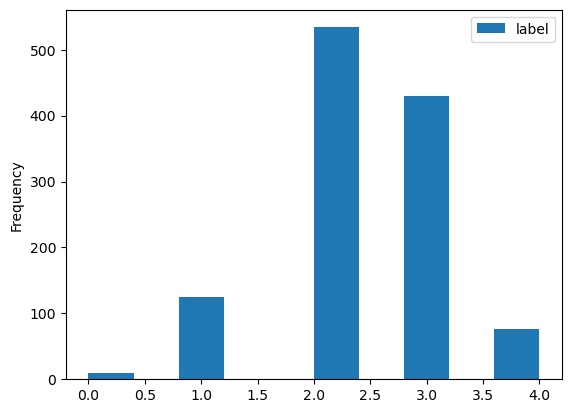

In [51]:
test_df.iloc[:, 1:3].plot.hist(histtype = 'bar')

In [60]:
test_df[['label', 'dp_rubert_pred']].groupby('label').mean()

,dp_rubert_pred
label,
0,2.222222
1,1.720000
2,2.117978
3,2.662791
4,3.513158


In [61]:
test_df[['label', 'dp_rubert_pred']].groupby('label').quantile(q = [i/10 for i in range(0, 11, 3)])

dp_rubert_pred
label                    
0     0.0             0.0
      0.3             1.4
      0.6             2.0
      0.9             4.0
1     0.0             1.0
      0.3             1.0
      0.6             1.0
      0.9             3.0
2     0.0             1.0
      0.3             2.0
      0.6             2.0
      0.9             3.0
3     0.0             1.0
      0.3             3.0
      0.6             3.0
      0.9             3.0
4     0.0             0.0
      0.3             4.0
      0.6             4.0
      0.9             4.0

In [63]:
test_df[['label', 'dp_rubert_pred', 'dp_rubert_score']].groupby('dp_rubert_pred').mean()

,label,dp_rubert_score
dp_rubert_pred,,
0,2.000000,0.671094
1,1.914286,0.703692
2,2.122685,0.790015
3,2.673077,0.729116
4,3.087719,0.736582


In [50]:
from sklearn.metrics import classification_report
print(classification_report(test_df['label'], test_df['dp_rubert_pred'], labels = [i for i in range(5)]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00       125
           2       0.38      0.25      0.30       534
           3       0.07      0.04      0.05       430
           4       0.04      0.28      0.08        76

   micro avg       0.16      0.15      0.15      1174
   macro avg       0.10      0.11      0.09      1174
weighted avg       0.20      0.15      0.16      1174



/home/kir/miniconda3/envs/my/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kir/miniconda3/envs/my/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kir/miniconda3/envs/my/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
metrics_df = test_df.groupby('name').apply(func = lambda x: groubpy_func_class_metrics(x, 'dp_rubert_pred')).reset_index().drop('level_1', axis = 1).set_index('name')
metrics_df.to_csv('bert_sentiment_metrics.csv')
metrics_df

,count,dist_1,dist_2,dist_3,dist_4,dist_5,accuracy,precision_micro,recall_micro,f1_score_micro
name,,,,,,,,,,
-1,281,21,205,36,14,0,0.693950,0.746242,0.693950,0.710726
252,5,0,5,0,0,0,1.000000,1.000000,1.000000,1.000000
Cian PLC (эмитент депозитарных расписок - The Bank of New York Mellon)\n,3,1,0,1,1,0,0.333333,0.500000,0.333333,0.666667
ETALON GROUP PLC (ЭТАЛОН ГРУП ПИЭЛСИ) (эмитент депозитарных расписок - The Bank of New York Mellon (Бэнк оф Нью Йорк Меллон)),10,2,4,4,0,0,0.600000,0.606667,0.600000,0.595238
Fix Price Group Ltd (Фикс Прайс Груп Лтд) (эмитент депозитарных расписок - The Bank of New York Mellon (Бэнк оф Нью Йорк Меллон)),4,1,2,0,1,0,0.750000,0.875000,0.750000,0.750000
...,...,...,...,...,...,...,...,...,...,...
"публичное акционерное общество ""Группа компаний ""Самолет""",28,3,4,15,6,0,0.571429,0.635931,0.571429,0.588736
"публичное акционерное общество ""Корпорация ВСМПО-АВИСМА""",1,0,1,0,0,0,1.000000,1.000000,1.000000,1.000000
"публичное акционерное общество ""НОВАТЭК""",25,3,8,13,1,0,0.640000,0.751059,0.640000,0.614000
